# Skeleton of an Variational Bayes Artificial Neural Network (BNN) in PyTorch applied to Nevada PFA Geothermal Resources Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

# from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

# from torchvision import models
from torchsummary import summary

import rasterio

import datetime
import time

from pathlib import Path
import sys

from tqdm.notebook import trange, tqdm

## BEGIN data preprocessing

### define a geotiff base map from PFA_ML study to use for affine transforms

In [2]:
path = '../../datasets/'

basemapFilename = 'BNN_(+)_q-0.05_avg-8192.tif'

basemapFile = path+basemapFilename

## define preprocessed data and trained model

In [3]:
# myHome = str(Path.home())

In [4]:
path = '../../datasets/'
modelPath = './'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'

modelFilename = 'BNN_model_trial_2.35.torch'

hf5File = path+filename
modelFile = modelPath+modelFilename

## load feature data

In [5]:
# careful! don't use 'w' or you will overwrite the file
f = pd.HDFStore(hf5File, 'r')
print (f.keys())
f.close()

['/X', '/XyInfo', '/dfInfo', '/dfn', '/nullIndexes', '/scaler', '/y']


In [6]:
# import h5py

# f = h5py.File(hf5File, 'r')

# def keys(f):
#     return [key for key in f.keys()]

# key_list = keys(f)
# print(key_list)

# f.close()

In [7]:
X = pd.read_hdf(hf5File, key='X')
XyInfo = pd.read_hdf(hf5File, key='XyInfo')
dfInfo = pd.read_hdf(hf5File, key='dfInfo')
dfn = pd.read_hdf(hf5File, key='dfn')
nullIndexes = pd.read_hdf(hf5File, key='nullIndexes')

In [8]:
print(X.shape, dfn.shape, nullIndexes.shape)

(725, 20) (1728000, 20) (30528,)


In [9]:
columns=dfn.columns.to_list()

In [10]:
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [11]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

]

print (len(featureSets))

1


In [12]:
feature_set = 0

trainingColumns = featureSets[feature_set]

trainingColumns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## load basemap geotiff and get affine transform

In [13]:
raster = rasterio.open(basemapFile)
baseMap = raster.read(1)

baseMap.shape

(1000, 1728)

In [14]:
# plt.imshow(baseMap)

In [15]:
fwd = raster.transform
print (fwd)

| 250.00, 0.00, 286202.69|
| 0.00,-250.00, 4508588.77|
| 0.00, 0.00, 1.00|


In [16]:
# test
rev = ~fwd
rev*fwd

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

## END data preprocessing

## predict over study area

In [17]:
Xall = dfn.copy()

## select only those features used for training

In [18]:
Xall = Xall[trainingColumns]

In [19]:
len(Xall)

1728000

In [20]:
Xall = Xall.copy().to_numpy()

# Xall

In [21]:
Xall.shape

(1728000, 10)

# Build model

In [22]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

LOADER_KWARGS = {}    
# LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

Using device: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Siamese Network

### BNN

In [23]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
#         epsilon = self.normal.sample(self.rho.size()).to(device)
        epsilon = self.normal.sample().to(device)
        return self.mu + self.sigma * epsilon
    
    def entropy(self, input):
#         entropy = 0.5 * torch.log(2 * math.pi * math.e * self.sigma**2)
        entropy = -self.normal.log_prob(input).exp() * self.normal.log_prob(input)
        return entropy.sum()

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [24]:
class Normal(object):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        self.normal = torch.distributions.Normal(loc=0.0, scale=self.scale)
        
    def sample(self):
        sample = self.normal.sample().to(device)
        return sample
    
    def entropy(self):
        entropy = self.normal.entropy()
        return entropy

    def log_prob(self, input):
        prob = self.normal.log_prob(input)
        return prob.sum()

## Bayesian modules

In [25]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = Normal(SCALEw)
        self.bias_prior   = Normal(SCALEb)

        self.log_prior = 0
        self.log_variational_posterior = 0
        
        self.weight_value = self.weight.mu
        self.bias_value = self.bias.mu
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample==True:            
            weight = self.weight.sample()
            bias = self.bias.sample()
        elif sample==False:
            weight = self.weight.mu
            bias = self.bias.mu
        elif sample==None:
            weight = self.weight_value
            bias = self.bias_value
        # save values for use in freezing network
        self.weight_value = weight
        self.bias_value = bias
            
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
class BayesianNetwork(nn.Module):
    def __init__(self, nFeatures, nHidden, nLabels, complexityWeight):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden   = nHidden
        self.nLabels   = nLabels
        
        self.complexityWeight = complexityWeight
        
        self.l1 = BayesianLinear(self.nFeatures, self.nHidden)
        self.l2 = BayesianLinear(self.nHidden, self.nHidden)
        self.l3 = BayesianLinear(self.nHidden, self.nLabels)
        
        self.LeakyRelu  = nn.LeakyReLU(0.1)
        self.BatchNorm  = nn.BatchNorm1d(self.nHidden)
        self.dropout    = nn.Dropout(p=0.3)
        self.LogSoftmax = nn.LogSoftmax(dim=1)   

    ###############################
    # forward method for single pass
    def forward_twin(self, x, sample=False):
        
        x = x.view(-1, self.nFeatures)
        
        x = self.l1(x, sample)
        x = self.LeakyRelu(x)

        x = self.l2(x, sample)
        
        return x
    
    ###############################
    # forward method for easy inference
    def forward_infer(self, x1, x2, sample=False):
        
        self.pdist = nn.PairwiseDistance(p=2)    
        # self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

        x1 = self.forward_twin(x1, sample=True)
        x2 = self.forward_twin(x2, sample=None)
        
        # cosine similarity: output=1 when similar, -1 when different ... do I need to scale this?
        # x12 = self.cos(x1, x2)
        # x12 = 1-x12 # distance
        
        # euclidean distance
        # pdist = nn.PairwiseDistance(p=2)
        x12 = self.pdist(x1, x2)
        x12 = torch.exp(-x12)
               
        return x12
   
    def mfvi_forward_infer(self, x1, x2, stat=None, q=None, sample_nbr=10):
        """
        Perform mean-field variational inference for the variational estimator model:
            Performs sample_nbr forward passes with uncertainty on the weights, 
            returning its mean and standard deviation
        """
        # similarities from all samples
        similarity = torch.stack([self.forward_infer(x1, x2, sample=True) 
                                  for _ in range(sample_nbr)])
        
        if   stat == 'mean':
            value = torch.mean(similarity, dim=0)
        elif stat == 'stddev':
            value = torch.std(similarity, dim=0)
        elif stat == 'mode':
            value, _ = torch.mode(similarity, dim=0)
        elif stat == 'quantile':
            q = torch.tensor([q]).to(device)
            value = torch.quantile(similarity, q, dim=0)
        else:
            value = torch.tensor([0.0])            
        return value

### load and use pretrained model

In [26]:
net = torch.load(modelFile)
net.eval()

print (net)
# summary(net, features.shape, col_names=("input_size", "output_size", "num_params"), verbose=2, depth=2);

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
  (LeakyRelu): LeakyReLU(negative_slope=0.1)
  (BatchNorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (LogSoftmax): LogSoftmax(dim=1)
)


## Inference to make Similarity Map

## (2) predict posterior distribution for specific sites in study area

#### (a) specify sites by rcIndex (['id_rc']), array([[r,c]]), or array([[utmE, utmN]])
#### (c) specify sites by UTM coordinates

## logger

In [27]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
formatter = logging.Formatter('%(message)s')

# fh = logging.FileHandler('log_report'+timeNow()+'.md')
fh = logging.FileHandler('log_report.md')
fh.setLevel(logging.INFO)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)

logger.addHandler(ch)

# logger.info(filename)
# logger.info(note+'\n')
logger.info('begin\n')

begin



## specify one case

In [28]:
testIdx = 8

In [29]:
# rcArray  = np.array([[0, 0], 
#                      [0, 0], 
#                      [0, 0]])

# rcIndex = ['R1C1']

# utmArray = np.array([[420033.75, 4301656.14], 
#                      [337158.24, 4456578.84], 
#                      [507429.92, 4383670.34]])

rcArray = np.array([])
rcIndex = np.array([])
utmArray = np.array([])
           
descriptionArray = ([['Argenta_Rise_1'],
                     ['Argenta_Rise_2'],
                     ['Argenta_Rise_3'],
                     ['Argenta_Rise_4'],
                     ['Site_3a'],
                     ['Site_3b'],
                     ['Site_3c'],
                     ['Site_3d'],
                     ['Gabbs_Valley']])

rcArray = np.array([[68, 931],
                    [46, 922],
                    [40, 937],
                    [20, 917],
                    [193, 699],
                    [140, 711],
                    [158, 430],
                    [168, 432],
                    [827, 535]])

rcArray = rcArray[testIdx]
siteDescription = descriptionArray[testIdx][0]

In [30]:
print (rcIndex, rcArray, utmArray, siteDescription)

[] [827 535] [] Gabbs_Valley


In [31]:
logger.info('')
logger.info('```')
logger.info('BNN pretrained Siamese Network with similarity=log(-EuclideanDistance)')
logger.info('site description: '+siteDescription)
logger.info('```')
logger.info('')


```
BNN pretrained Siamese Network with similarity=log(-EuclideanDistance)
site description: Gabbs_Valley
```



In [32]:
if len(rcArray) > 0:
    rcArray.shape = (-1,2)
    
    rcIndex = []
    utmArray = []
    for row, col in rcArray:
        rcString = 'R'+str(1000-row)+'C'+str(col+1)
        rcIndex.append(rcString)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

elif len(utmArray) > 0:    
    utmArray.shape = (-1,2)
    
    logger.info('')
    logger.info('```')
    logger.info('site UTM: '+str(utmArray))
    logger.info('```')
    logger.info('')
    
    rcArray = []
    for UTM_E_NAD83, UTM_N_NAD83 in utmArray:
        (c,r) = ~fwd*(UTM_E_NAD83, UTM_N_NAD83)
        rcArray.append([int(r), int(c)])
    rcArray = np.asarray(rcArray)

    rcIndex = []
    utmArray = []
    for row, col in rcArray:
        rcString = 'R'+str(1000-row)+'C'+str(col+1)
        rcIndex.append(rcString)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

elif len(rcIndex) > 0:
    
    row = np.array([])
    col = np.array([])
    for s in rcIndex:
        row = np.append(row,int(eval(s.split('R')[1].split('C')[0])))
        col = np.append(col,int(eval(s.split('R')[1].split('C')[1])))
    # row = 999-(row-1).astype('int')
    row = (1000-row).astype('int')

    col = (col-1).astype('int')
    rcArray = np.array([row, col]).T

    utmArray = []
    for row, col in rcArray:
        # rcIndex = 'R'+str(1000-row)+'C'+str(col+1)
        (UTM_E_NAD83, UTM_N_NAD83) = fwd*(col, row)
        utmArray.append([UTM_E_NAD83, UTM_N_NAD83])
    utmArray = np.asarray(utmArray)

print (rcIndex)
print (rcArray)
print (utmArray)

['R173C536']
[[827 535]]
[[ 419952.6902 4301838.7659]]


In [33]:
logger.info('')
logger.info('```')
logger.info('pixel rowcol '+str(rcArray))
logger.info('pixel id_rc: '+str(rcIndex))
logger.info('pixel UTM:   '+str(utmArray))
logger.info('```')
logger.info('')


```
pixel rowcol [[827 535]]
pixel id_rc: ['R173C536']
pixel UTM:   [[ 419952.6902 4301838.7659]]
```



In [34]:
idx = []
for RC in rcIndex:
    i = dfInfo[dfInfo['id_rc'] == RC].index.tolist()[0]
    idx.append(i)
    print (i, RC)
# print (idx)

297751 R173C536


### select features from dataframe

In [35]:
dfXtest = dfn.loc[idx][trainingColumns]
# dfXtest = dfn.loc[idx][columns]

In [36]:
Xtest = torch.Tensor(dfXtest.to_numpy())[0]

Xtest.shape

torch.Size([10])

## predict whole study area

In [37]:
# stat = 'quantile'
# quantile = 0.2

stat = 'mean'

# stat = 'stddev'

# N = 8192
# N = 1024
N = 512

In [38]:
net.eval()

eval_loader = DataLoader(Tensor(Xall).to(device), shuffle=False, 
                         batch_size=4096, drop_last=False)

sAll = []

for features in tqdm(eval_loader):
    with torch.no_grad():
        
        if stat == 'quantile':
            statstr = 'q'+str(quantile)
            s = net.mfvi_forward_infer(Xtest.to(device), features,
                                       stat='quantile', q=quantile, sample_nbr=N)
        elif stat == 'mean':
            statstr = stat
            s = net.mfvi_forward_infer(Xtest.to(device), features, 
                                       stat='mean', q=None, sample_nbr=N)
        elif stat == 'stddev':
            statstr = stat
            s = net.mfvi_forward_infer(Xtest.to(device), features, 
                                       stat='stddev', q=None, sample_nbr=N)
        
        s = s.squeeze()
        sAll.append(s)
        
sAll = torch.cat(sAll, dim=0)


  0%|          | 0/422 [00:00<?, ?it/s]

In [39]:
sAll = sAll.cpu().detach().numpy()
sAll.shape

(1728000,)

## plot a histogram


![PDF](./fig0_Gabbs_Valley_pBNN_siamese_PDF_mean_8_avg_512.png "PDF")



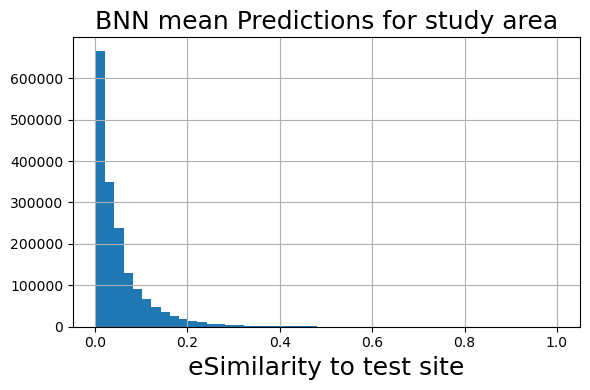

In [40]:
plt.rc('figure', figsize=(6,4))

# plt.hist(yall[:,0],50);
plt.hist(sAll,50);
## plt.hist(yall[yall.>0.5],50);
# plt.axis([0,1,0,100000])
plt.grid(True)

plt.title('BNN '+statstr+' Predictions for study area',fontsize=18)
# plt.xlabel('distance from test site',fontsize=18)
plt.xlabel('eSimilarity to test site',fontsize=18)

plt.tight_layout()

figName = 'fig0_'+siteDescription+'_pBNN_siamese_PDF_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig0_BNN_PDF_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![PDF](./'+figName+' "PDF")')
logger.info('')

## make a map

In [41]:
# mask nulls
sAll[nullIndexes] = np.nan

In [42]:
# reshape and flipud
img = np.reshape(sAll,(1000,-1))
img = np.flipud(img)
img.shape

(1000, 1728)

### get benchmark sites coordinates, use TrainCode=1

In [43]:
XyInfo.columns

Index(['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo',
       'TrainCodeNeg', 'TrainCodePos', 'TrainCodePosT130', 'PosSite130_Id',
       'PosSite130_Distance', 'PosSite_Id', 'PosSite_Distance', 'NegSite_Id',
       'NegSite_Distance', 'Local_polygon_Id', 'Local_polygon_overlap_Id'],
      dtype='object')

In [44]:
benchmarks = XyInfo[['row', 'column', 'TrainCodePos']].copy()
benchmarks.rename({'TrainCodePos': 'label'}, axis='columns', inplace=True)

In [45]:
benchmarks = benchmarks.loc[(XyInfo.TrainCodePos==1) | (XyInfo.TrainCodeNeg==1)]
benchmarks['label'][benchmarks.label > 1] = 0

In [46]:
benchmarks

,row,column,label
1629211,942.0,1435.0,1
1427233,825.0,1633.0,0
390564,226.0,36.0,1
1230984,712.0,648.0,1
1199875,694.0,643.0,1
...,...,...,...
1578088,913.0,424.0,1
369369,213.0,1305.0,1
639673,370.0,313.0,1
392038,226.0,1510.0,0


### fix indexing for matplotlib imshow ... row, col referenced from upper left

In [47]:
indexB = benchmarks.index.astype(int).to_numpy()

In [48]:
benchmarks = benchmarks.astype(int)
benchmarks = benchmarks.to_numpy()

In [49]:
rowB = 999-benchmarks[:,0]
colB = benchmarks[:,1]
labelB = benchmarks[:,2]

In [50]:
rcArray

array([[827, 535]])

In [51]:
c = rcArray[0][1]
r = rcArray[0][0]

### plot

In [52]:
vmin = 0
vmax = 1


![Map](./fig1_Gabbs_Valley_pBNN_siamese_mean_8_avg_512.png "Map")



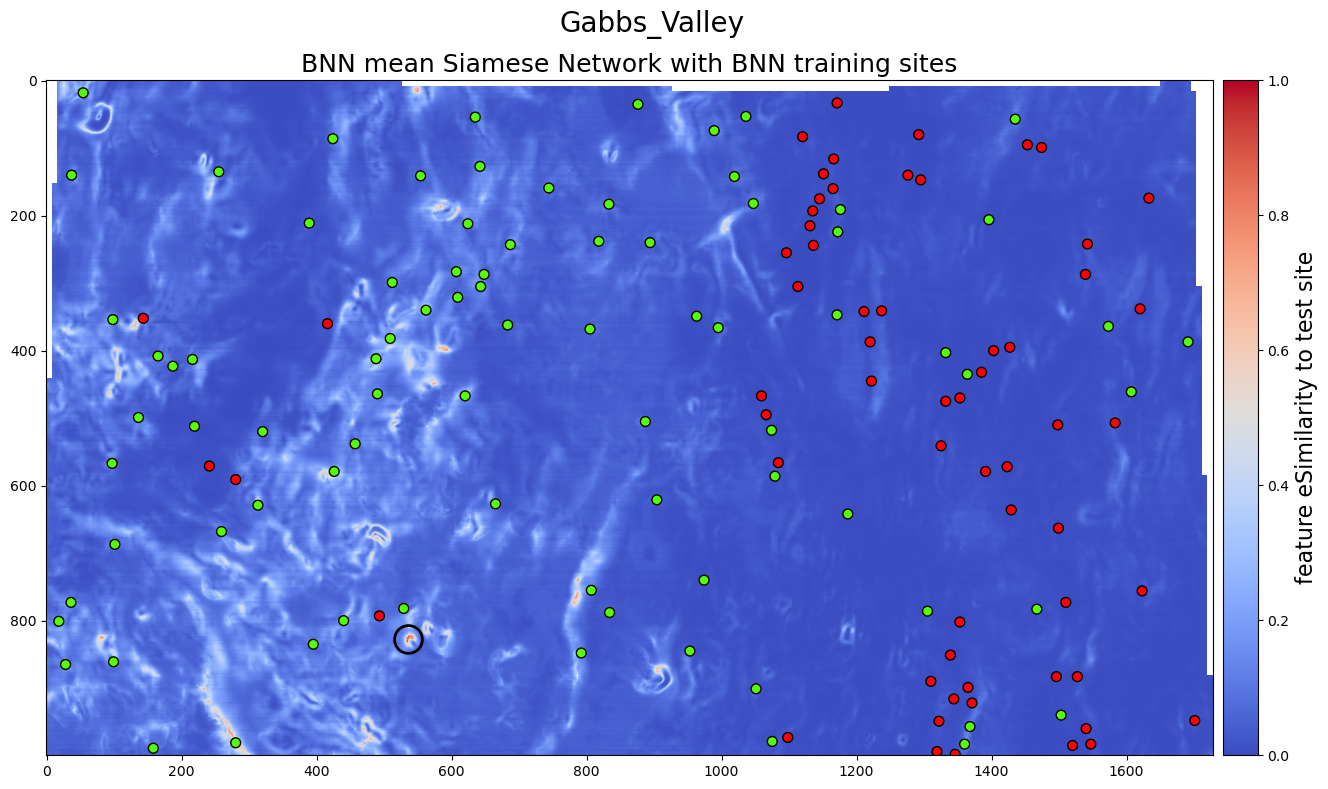

In [53]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

# im = plt.imshow(baseMap*img, origin='upper', cmap='coolwarm', 
im = plt.imshow(img, origin='upper', cmap='coolwarm',
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

plt.plot(c,r, marker='o', fillstyle='none', 
         # markeredgecolor='orange', markeredgewidth=2, ms=20)
         markeredgecolor='black', markeredgewidth=2, ms=20)

plt.scatter(colB, rowB, c=labelB, s=50, cmap='prism', edgecolor='k')

# plt.title('"new" Fairway - categorical localK', fontsize=18)
# plt.title('ANN model '+str(n_run), fontsize=18)
plt.title('BNN '+statstr+' Siamese Network with BNN training sites', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im, cax=cax)
# cb.set_label('feature euclidean distance from site', fontsize=16)
cb.set_label('feature eSimilarity to test site', fontsize=16)

plt.tight_layout()

# figName = 'fig1_BNN_'+statstr+'_'+str(testIdx)+'.png'
figName = 'fig1_'+siteDescription+'_pBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig1_BNN_'+statstr+'_lognorm_'+str(testIdx)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')


![Map](./fig2_Gabbs_Valley_pBNN_percentile_mean_8_avg_512.png "Map")



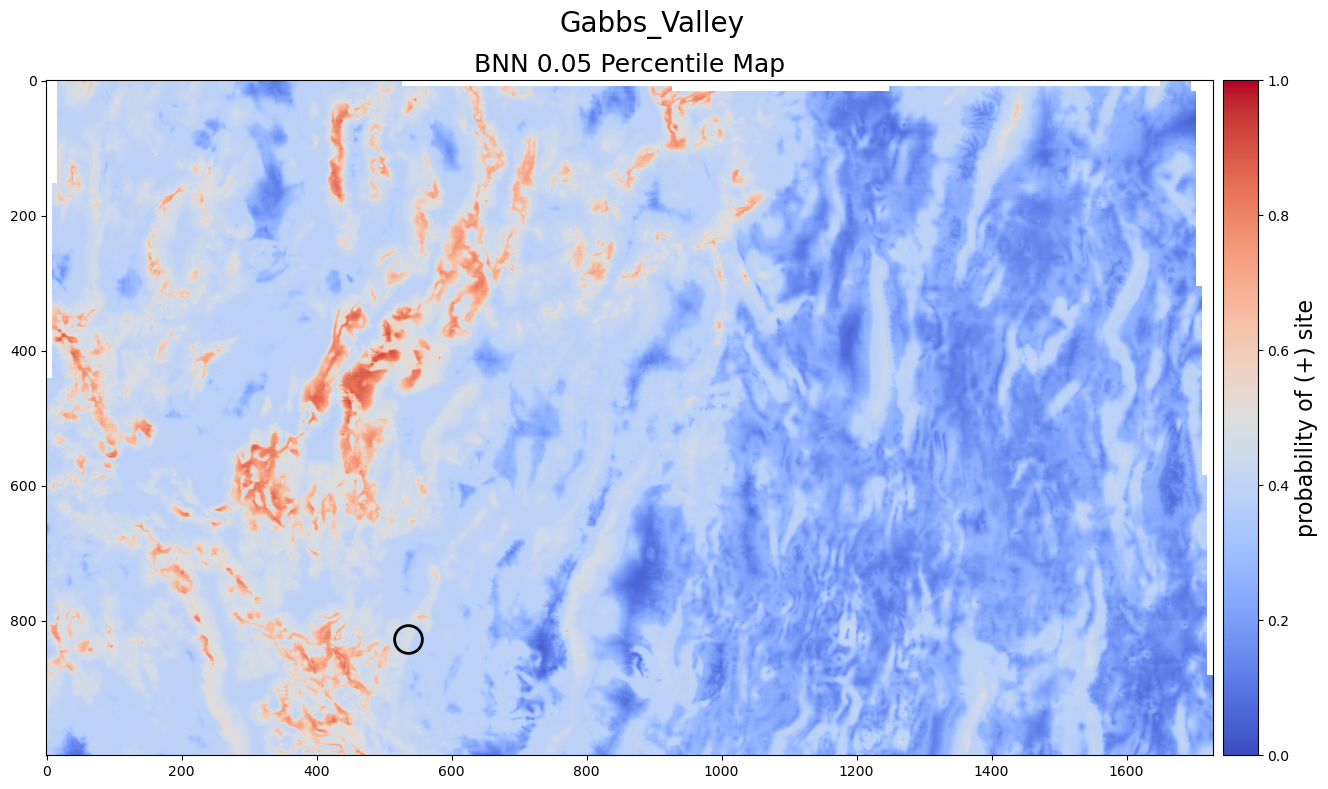

In [54]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

im0 = ax.imshow(baseMap, origin='upper', cmap='coolwarm', 
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

ax.plot(c,r, marker='o', fillstyle='none', 
         markeredgecolor='black', markeredgewidth=2, ms=20)

ax.set_title('BNN 0.05 Percentile Map', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im0, cax=cax)
cb.set_label('probability of (+) site', fontsize=16)
# ax[0].scatter(colB, rowB, c=-labelB, s=50, cmap='prism', edgecolor='k')


plt.tight_layout()

# figName = 'fig2_'+siteDescription+'_BNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
figName = 'fig2_'+siteDescription+'_pBNN_percentile_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
# figName = 'fig2_BNN_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
plt.savefig(figName, dpi=300)
logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')


![Map](./fig3_Gabbs_Valley_pBNN_siamese_mean_8_avg_512.png "Map")



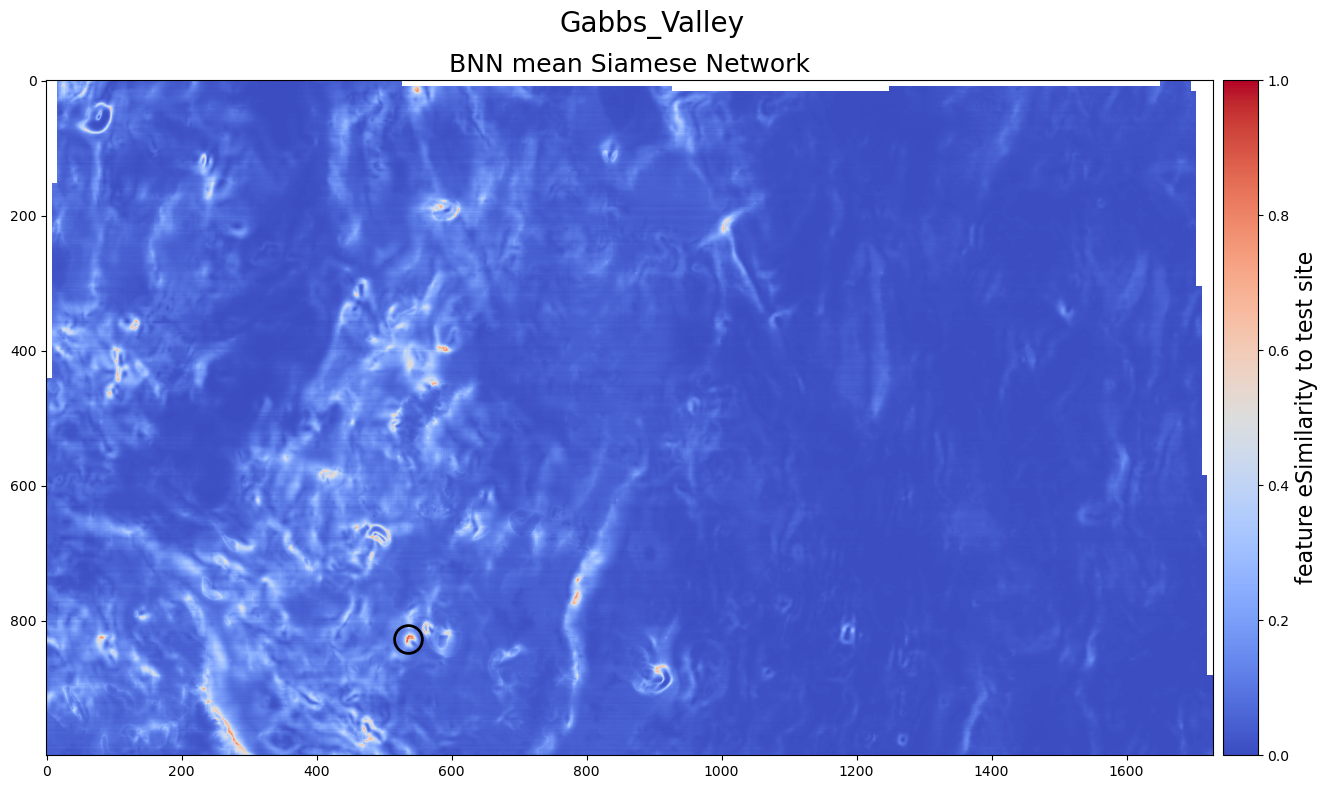

In [55]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize=(16,8))

plt.suptitle(siteDescription, fontsize=20)

im0 = ax.imshow(img, origin='upper', cmap='coolwarm', 
                norm=colors.Normalize(vmin=vmin, vmax=vmax),
               )

ax.plot(c,r, marker='o', fillstyle='none', 
         markeredgecolor='black', markeredgewidth=2, ms=20)

ax.set_title('BNN '+statstr+' Siamese Network', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im0, cax=cax)
cb.set_label('feature eSimilarity to test site',fontsize=16)

plt.tight_layout()

figName = 'fig3_'+siteDescription+'_pBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.png'
plt.savefig(figName, dpi=300)

logger.info('')
logger.info('![Map](./'+figName+' "Map")')
logger.info('')

## save maps as geotiffs

In [56]:
import osgeo.gdal as gdal
import osgeo.osr as osr

In [57]:
transform = [286202.6902, 250.0, 0.0, 4508588.7659, 0.0, -250.0]

In [58]:
img0 = img.copy()
# img0 = np.flipud(img)
# img1 = np.flipud(imgm)
# img2 = np.flipud(imgmax)

In [59]:
height = img0.shape[0]
width = img0.shape[1]
print (width, height)

1728 1000


In [60]:
# open a new file
# geotiffFile = 'argenta_pretrained_BNN_siamese'+'.tif'
geotiffFile = siteDescription+'_pBNN_siamese_'+statstr+'_'+str(testIdx)+'_avg_'+str(N)+'.tif'

driver = gdal.GetDriverByName("GTiff")
outRaster = driver.Create(geotiffFile, width, height, 1, gdal.GDT_Float32)

# use PFA's geo-transform found above
outRaster.SetGeoTransform(transform)

# assign color band
outband = outRaster.GetRasterBand(1)
outband.WriteArray(img0)

# set coordinate reference system
outRasterSRS = osr.SpatialReference() # create instance of class
outRasterSRS.ImportFromEPSG(26911)    # set to specific coordinate reference system
# outRasterSRS.ImportFromWkt(raster.GetProjectionRef()) # or could use SRS from before
outRaster.SetProjection(outRasterSRS.ExportToWkt()) # set the projection

# flush output to file
outband.FlushCache()

# this closes the files
raster = None
outRaster = None